In [1]:
from stableemrifisher.fisher import StableEMRIFisher
from few.waveform import GenerateEMRIWaveform
import matplotlib.pyplot as plt
import os
from pathlib import Path
import cupy as xp
import numpy as np
use_gpu=True

startup


In [2]:
#set initial parameters
M = 1e6
mu = 10
a = 0.9
p0 = 8.05
e0 = 0.1
iota0 = 0.0 #equatorial
Y0 = np.cos(iota0)
Phi_phi0 = 2
Phi_theta0 = 3
Phi_r0 = 1.5

qS = 0.2
phiS = 0.2
qK = 0.8
phiK = 0.8
dist = 1
mich = True #mich = True implies output in hI, hII long wavelength approximation
dt = 10.0
T = 0.1

In [3]:
inspiral_kwargs = {
        "DENSE_STEPPING": 0,
        "max_init_len": int(1e3),
        "err": 1e-10,  # To be set within the class
        "use_rk4": True,
        }

# keyword arguments for summation generator (AAKSummation)
sum_kwargs = {
    "use_gpu": True,  # GPU is available for this type of summation
    "pad_output": True,
}

amplitude_kwargs = {
    }

outdir = 'example_outdir'
suffix = '1'
Path(outdir).mkdir(exist_ok=True)
waveform_model = GenerateEMRIWaveform('FastSchwarzschildEccentricFlux', return_list=True, inspiral_kwargs=inspiral_kwargs, sum_kwargs=sum_kwargs, use_gpu=use_gpu)

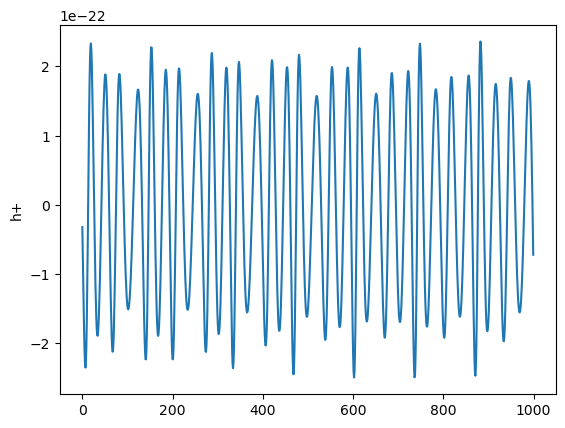

In [4]:
waveform = xp.asarray(waveform_model(M, mu, a, p0, e0, Y0, 
                          dist, qS, phiS, qK, phiK, 
                          Phi_phi0, Phi_theta0, Phi_r0, 
                          mich=mich, dt=dt, T=T)).get()

plt.plot(waveform[0][-1000:])
plt.ylabel("h+")
plt.savefig(os.path.join(outdir, f"waveform_{suffix}.png"))
plt.show()

Body is not plunging, Fisher should be stable.
Computing SNR for parameters: {'M': 1000000.0, 'mu': 10, 'a': 0.9, 'p0': 8.05, 'e0': 0.1, 'Y0': 1.0, 'dist': 1, 'qS': 0.2, 'phiS': 0.2, 'qK': 0.8, 'phiK': 0.8, 'Phi_phi0': 2, 'Phi_theta0': 3, 'Phi_r0': 1.5}
Waveform Generated. SNR: 18.2416714120722
The optimal source SNR is <= 20. The Fisher approximation may not be valid!
calculating stable deltas...
Time taken to compute stable deltas is 33.55140447616577 seconds
calculating Fisher matrix...
Finished derivatives
Calculated Fisher is *atleast* positive-definite.
Time taken to compute FM is 4.420438528060913 seconds


(array([[ 6.79591900e-01, -1.57227768e+03,  1.24106240e+05,
          9.25948722e+04],
        [-1.57227768e+03,  3.93761068e+06, -2.92650933e+08,
         -2.10949745e+08],
        [ 1.24106240e+05, -2.92650933e+08,  2.29985498e+10,
          1.68181736e+10],
        [ 9.25948722e+04, -2.10949745e+08,  1.68181736e+10,
          1.26561797e+10]]),
 array([[ 1.85489835e+05,  8.69013650e+00, -1.38126593e-01,
         -1.02868234e+00],
        [ 8.69013650e+00,  4.12461774e-04, -6.36999722e-06,
         -4.82390161e-05],
        [-1.38126593e-01, -6.36999722e-06,  1.06316647e-07,
          7.63106517e-07],
        [-1.02868234e+00, -4.82390161e-05,  7.63106517e-07,
          5.70801344e-06]]))

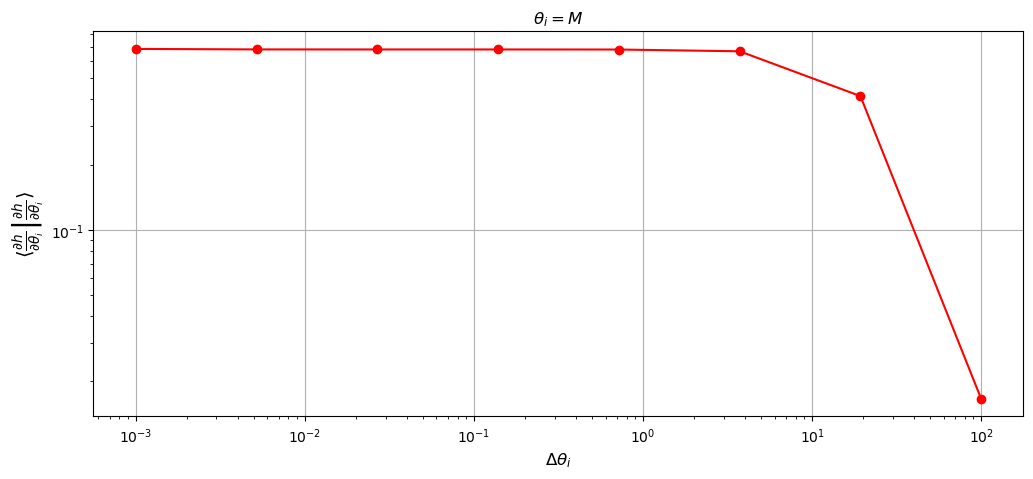

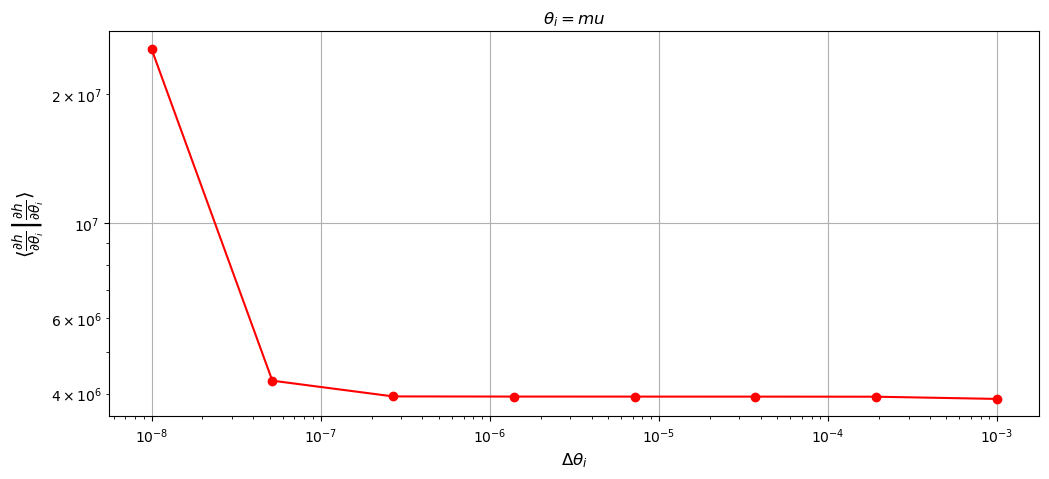

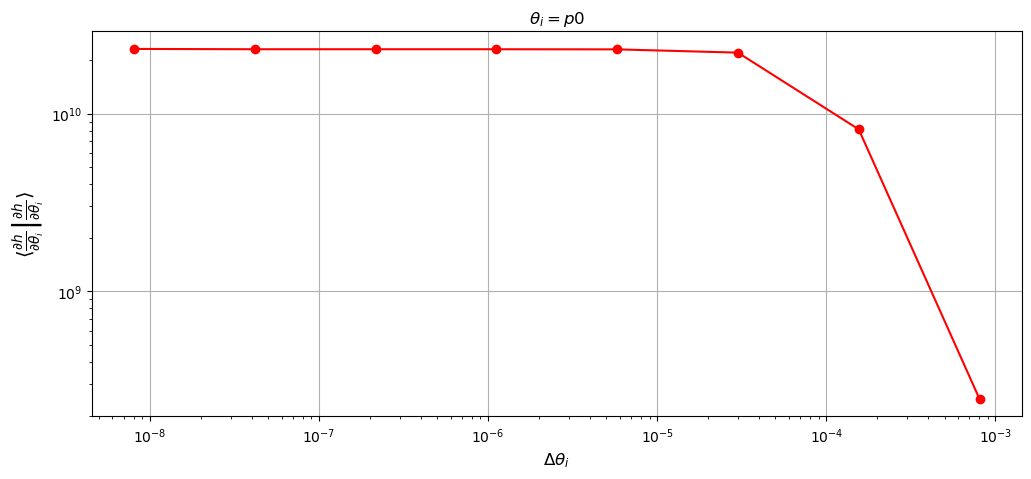

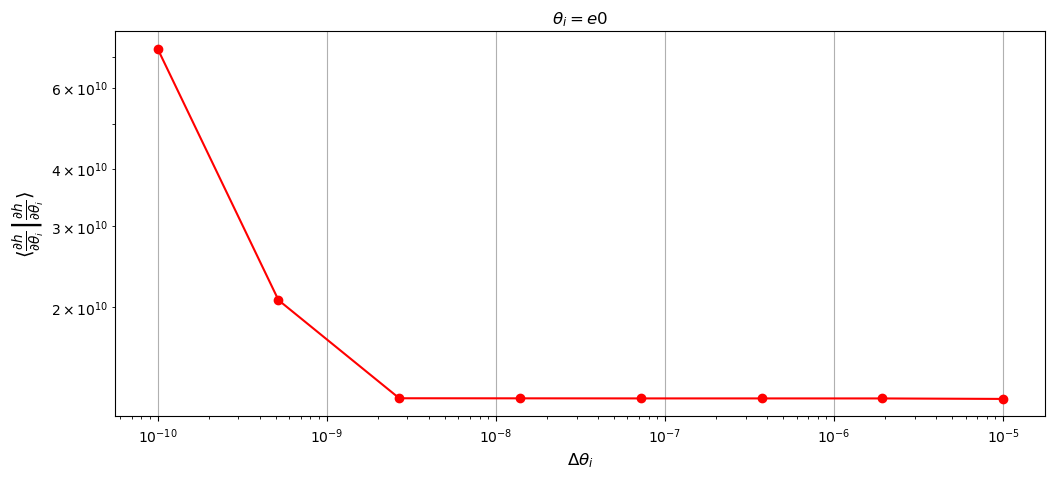

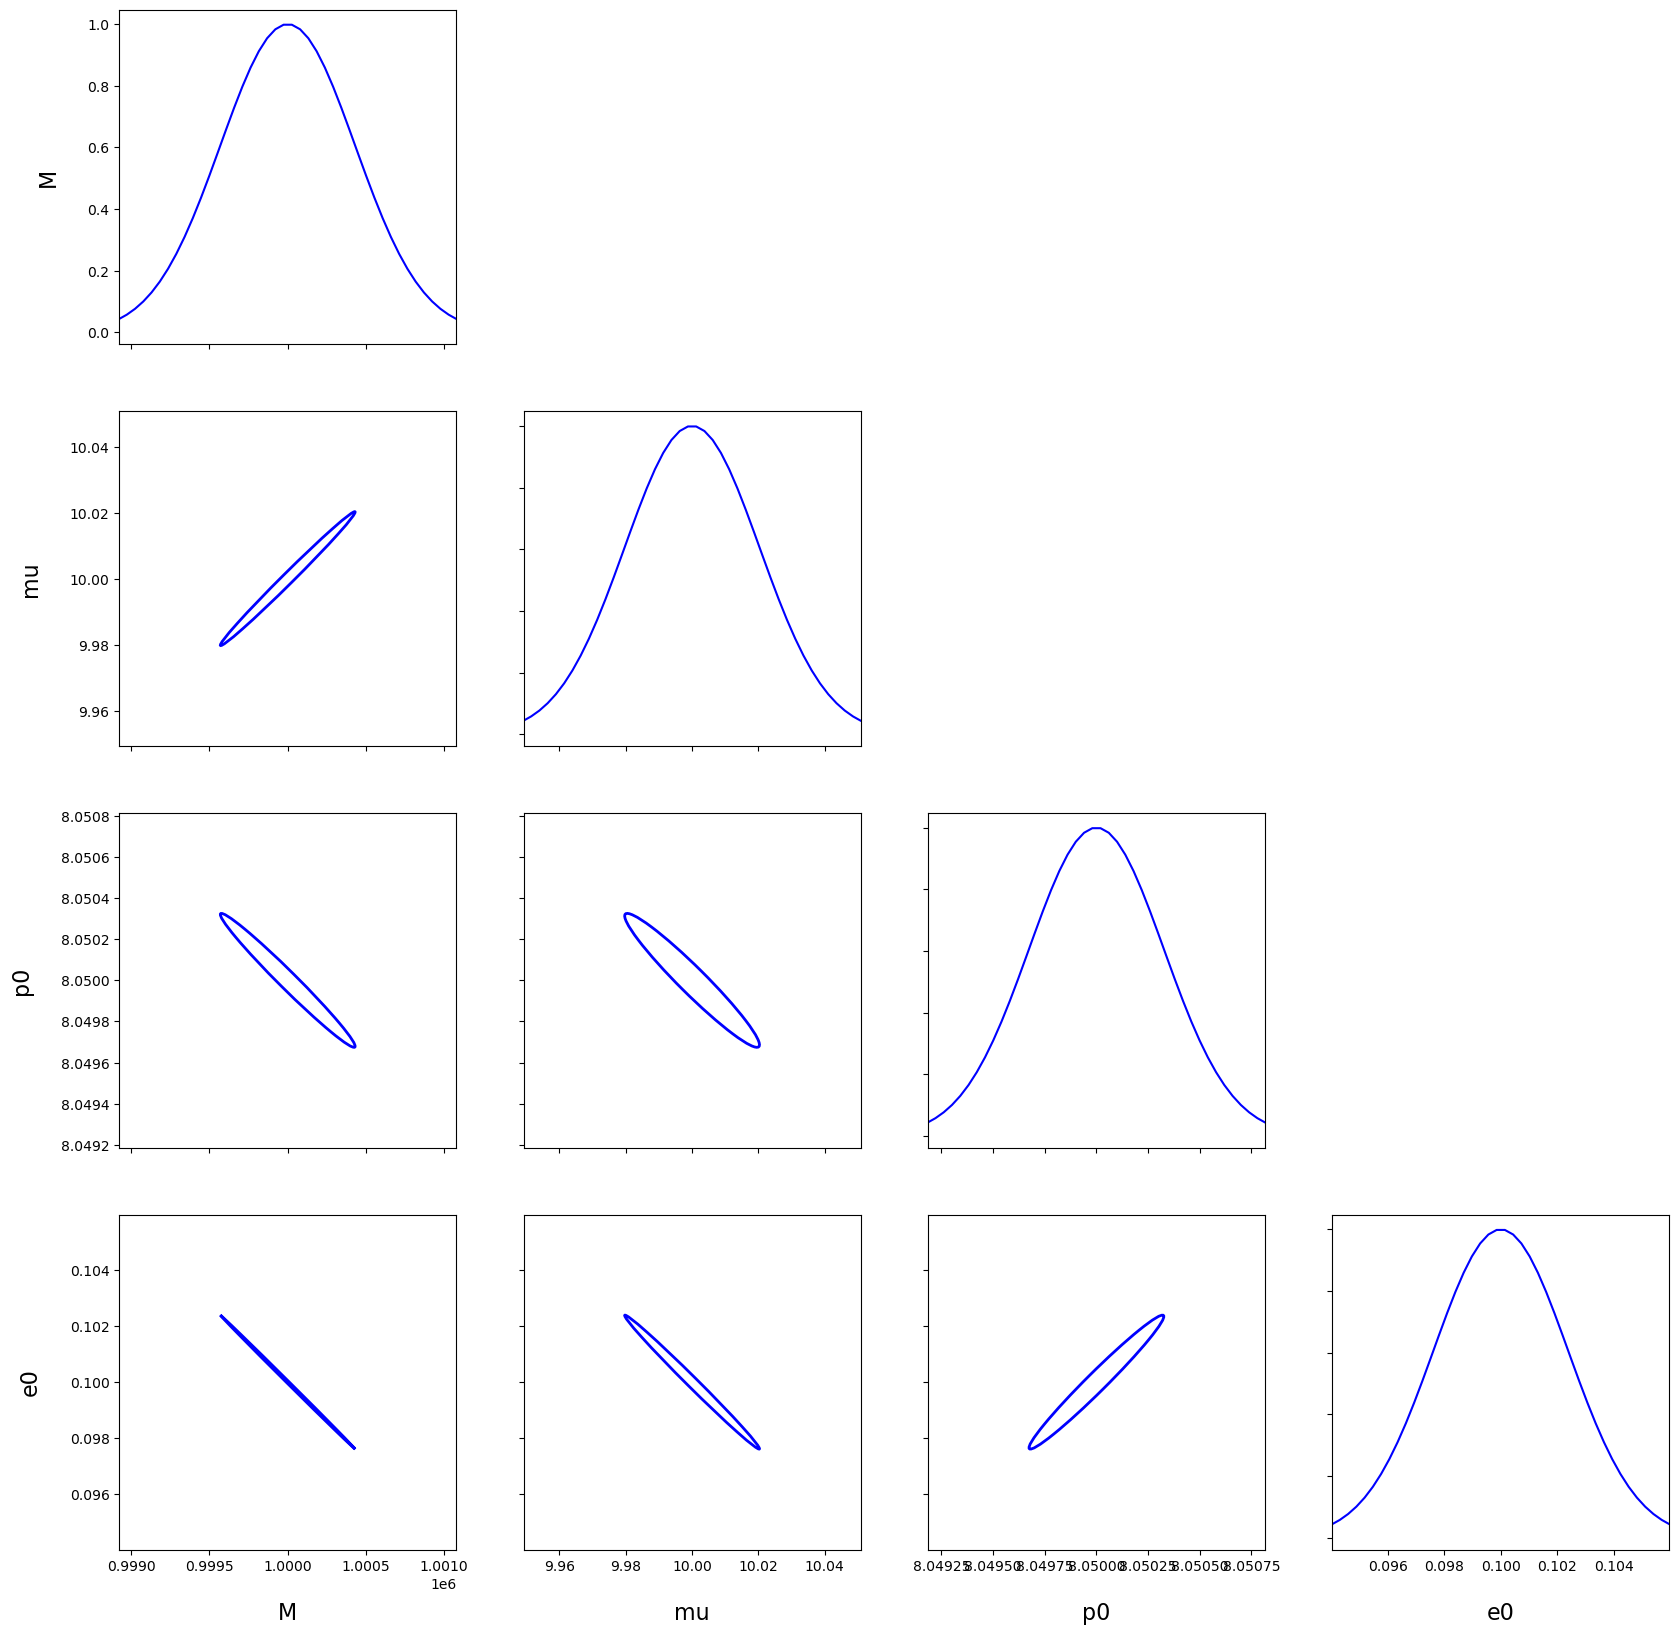

In [5]:
#varied parameters
param_names = ['M','mu','p0','e0']

#initialization
fish = StableEMRIFisher(M, mu, a, p0, e0, Y0, dist, qS, phiS, qK, phiK,
              Phi_phi0, Phi_theta0, Phi_r0, dt=dt, T=T, EMRI_waveform_gen=waveform_model,
              param_names=param_names, stats_for_nerds=False, use_gpu=True,
              filename=outdir, suffix=suffix,CovEllipse=True, live_dangerously=False,stability_plot=True)

#execution
fish()

100%|█████████████████████████████████████████████| 4/4 [00:11<00:00,  2.84s/it]


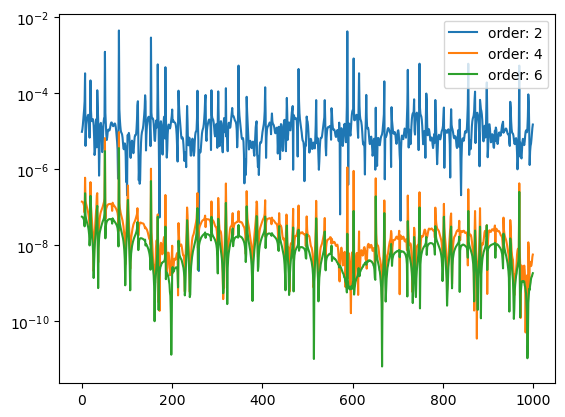

In [11]:
from stableemrifisher.fisher.derivatives import derivative
from tqdm import tqdm

deriv_orders = [2, 4, 6, 8]
outderivs = []
for deriv in tqdm(deriv_orders):
    outderivs.append(derivative(waveform_model, fish.wave_params, 'e0', 1e-6, order=deriv, use_gpu=True, waveform_kwargs=fish.waveform_kwargs)[0].get())

for i in range(len(deriv_orders)-1):
    plt.semilogy(abs(1 - outderivs[i][-1000:]/outderivs[-1][-1000:]),label=f'order: {deriv_orders[i]}')

plt.legend()